# Featuretools : Automated Feature Engineering

Thera are six different datasets in addition to train and test data. To improve performance, we need to methodically integrate those dataset into the train and the test data. Here I am going to use Featuretools library to incorportate those datasets. 

In [3]:
# Importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



from sklearn.multiclass import  OneVsRestClassifier

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

In [4]:
# A function to reduce memory. 
# Acknowledgement to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

 ##### I am using only a small subset of data so that I can perform all the operation fast. Before putting it into our model, I will use the whole dataset.  

In [35]:
train = reduce_mem(pd.read_csv(
    "DataSet/application_train.csv",
    encoding = 'unicode_escape').sort_values(
    "SK_ID_CURR").reset_index(
    drop = True))
train.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
train.shape

(307511, 122)

In [15]:
os.listdir("DataSet")


['HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 '.application_test.csv.icloud',
 'previous_application.csv',
 '.bureau.csv.icloud',
 'bureau_balance.csv',
 'sample_submission.csv']

In [42]:
test = reduce_mem(pd.read_csv(
    "DataSet/application_test.csv",
    encoding = 'unicode_escape').sort_values(
    "SK_ID_CURR").reset_index(
    drop = True))
test.head()


Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
test.shape

(48744, 121)

In [41]:
bureau = reduce_mem(pd.read_csv(
    "DataSet/bureau.csv",
    encoding = 'unicode_escape').sort_values(
    ["SK_ID_CURR", "SK_ID_BUREAU"]).reset_index(
    drop = True))
bureau.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
1,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
2,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
3,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
4,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


In [42]:
bureau_balance = reduce_mem(pd.read_csv(
    "DataSet/bureau_balance.csv",
    encoding = 'unicode_escape').sort_values(
    "SK_ID_BUREAU").reset_index(
    drop = True))
bureau_balance.head()


Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,-7,C
1,5001709,-3,C
2,5001709,-4,C
3,5001709,-5,C
4,5001709,-6,C


In [43]:
POS_CASH_balance= reduce_mem(pd.read_csv(
    "DataSet/POS_CASH_balance.csv",
    encoding = 'unicode_escape').sort_values(
    ["SK_ID_CURR", "SK_ID_PREV"]).reset_index(
    drop = True))

POS_CASH_balance.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1369693,100001,-53,4.0,0.0,Completed,0,0
1,1369693,100001,-54,4.0,1.0,Active,0,0
2,1369693,100001,-57,4.0,4.0,Active,0,0
3,1369693,100001,-55,4.0,2.0,Active,0,0
4,1369693,100001,-56,4.0,3.0,Active,0,0


In [44]:
credit_card_balance= reduce_mem(pd.read_csv(
    "DataSet/credit_card_balance.csv",
    encoding = 'unicode_escape').sort_values(
    ["SK_ID_CURR","SK_ID_PREV"]).reset_index(
    drop = True))
credit_card_balance.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
2,1489396,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
3,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
4,1489396,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


In [45]:
previous_application= reduce_mem(pd.read_csv(
    "DataSet/previous_application.csv",
    encoding = 'unicode_escape').sort_values(
    ["SK_ID_CURR", "SK_ID_PREV"]).reset_index(
    drop = True))
previous_application.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1369693,100001,Consumer loans,3951.000000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
1,1038818,100002,Consumer loans,9251.775391,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
2,1810518,100003,Cash loans,98356.992188,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
3,2396755,100003,Consumer loans,6737.310059,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,2636178,100003,Consumer loans,64567.664062,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0


In [46]:
installments_payments= reduce_mem(pd.read_csv(
    "DataSet/installments_payments.csv",
    encoding = 'unicode_escape').sort_values(
    ["SK_ID_CURR", "SK_ID_PREV"]).reset_index(
    drop = True))
installments_payments.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1369693,100001,1.0,1,-1709.0,-1715.0,3951.000000,3951.000000
1,1369693,100001,1.0,2,-1679.0,-1715.0,3951.000000,3951.000000
2,1369693,100001,2.0,4,-1619.0,-1628.0,17397.900391,17397.900391
3,1369693,100001,1.0,3,-1649.0,-1660.0,3951.000000,3951.000000
4,1851984,100001,1.0,2,-2916.0,-2916.0,3982.050049,3982.050049


In [47]:
app_train = train.copy()
app_test = test.copy()

In [48]:
# Combining training and test data so that they get equal treatments.
app_train["set"]= "train"
app_test["set"]="test"
app_test["TARGET"] = np.nan

In [49]:
train_test= app_train.append(app_test, ignore_index =True)
train_test.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,set
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.014900,"Stone, brick",WEDNESDAY,0.972168,0.972168,0.972168,0.619141,0.624512,0.634277,train
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071411,Block,MONDAY,0.984863,0.984863,0.984863,0.795898,0.798828,0.804199,train
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN,train
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN,train
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN,train


## Entity Set

In [50]:
#Creating an empty Entity set 
es = ft.EntitySet(id ="credit_clients")

In [51]:
# dataframes containing a unique index
es = es.entity_from_dataframe(entity_id = "train_test",
                              dataframe = train_test,
                             index = "SK_ID_CURR")
es = es.entity_from_dataframe(entity_id = "bureau",
                              dataframe = bureau,
                             index = "SK_ID_BUREAU")
es = es.entity_from_dataframe(entity_id = "previous_application",
                              dataframe = previous_application,
                             index = "SK_ID_PREV")

In [52]:
# dataframes containing no unique index
es = es.entity_from_dataframe(entity_id = "credit_card_balance",
                              dataframe = credit_card_balance,
                              make_index = True,
                             index = "credit_card_balance_id")
es = es.entity_from_dataframe(entity_id = "installments_payments",
                              dataframe = installments_payments,
                              make_index = True,
                             index = "installments_payments_id")
es = es.entity_from_dataframe(entity_id = "POS_CASH_balance",
                              dataframe = POS_CASH_balance,
                              make_index = True,
                             index = "POS_CASH_balance_id")
es = es.entity_from_dataframe(entity_id = "bureau_balance",
                              dataframe = bureau_balance,
                              make_index = True,
                             index = "bureau_balance_id")

## Realationships

In [53]:
# Defining relationships among entities
traintest_bureau = ft.Relationship(es["train_test"]["SK_ID_CURR"],
                                  es["bureau"]["SK_ID_CURR"])

bureau_bureaubalance = ft.Relationship(es["bureau"]["SK_ID_BUREAU"],
                                  es["bureau_balance"]["SK_ID_BUREAU"])


traintest_previousapplication = ft.Relationship(es["train_test"]["SK_ID_CURR"],
                                  es["previous_application"]["SK_ID_CURR"])


previousapplication_POSCASHbalance = ft.Relationship(es["previous_application"]["SK_ID_PREV"],
                                  es["POS_CASH_balance"]["SK_ID_PREV"])

previousapplication_installmentspayments = ft.Relationship(es["previous_application"]["SK_ID_PREV"],
                                  es["installments_payments"]["SK_ID_PREV"])
previousapplication_creditcardbalance = ft.Relationship(es["previous_application"]["SK_ID_PREV"],
                                  es["credit_card_balance"]["SK_ID_PREV"])

In [54]:
# Adding the defined relationships
es = es.add_relationships([traintest_bureau,bureau_bureaubalance,
                           bureau_bureaubalance,
                          traintest_previousapplication,
                          previousapplication_POSCASHbalance,
                           previousapplication_installmentspayments,
                           previousapplication_creditcardbalance
                          ])

2018-09-14 17:09:02,564 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU>


In [55]:
es

Entityset: credit_clients
  Entities:
    train_test [Rows: 356255, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    previous_application [Rows: 1670214, Columns: 37]
    credit_card_balance [Rows: 3840312, Columns: 24]
    installments_payments [Rows: 13605401, Columns: 9]
    POS_CASH_balance [Rows: 10001358, Columns: 9]
    bureau_balance [Rows: 27299925, Columns: 4]
  Relationships:
    bureau.SK_ID_CURR -> train_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous_application.SK_ID_CURR -> train_test.SK_ID_CURR
    POS_CASH_balance.SK_ID_PREV -> previous_application.SK_ID_PREV
    installments_payments.SK_ID_PREV -> previous_application.SK_ID_PREV
    credit_card_balance.SK_ID_PREV -> previous_application.SK_ID_PREV

## Feature Primitives

#### Aggregation

In [56]:
primitives = ft.list_primitives()
primitives[primitives["type"]=='aggregation'].head(15)

,name,type,description
0,num_true,aggregation,Finds the number of 'True' values in a boolean.
1,last,aggregation,Returns the last value.
2,n_most_common,aggregation,Finds the N most common elements in a categori...
3,num_unique,aggregation,Returns the number of unique categorical varia...
4,sum,aggregation,Counts the number of elements of a numeric or ...
5,std,aggregation,Finds the standard deviation of a numeric feat...
6,trend,aggregation,Calculates the slope of the linear trend of va...
7,max,aggregation,Finds the maximum non-null value of a numeric ...
8,mode,aggregation,Finds the most common element in a categorical...
9,min,aggregation,Finds the minimum non-null value of a numeric ...


#### Transformation

In [57]:
primitives[primitives["type"]=='transform'].head(15)

,name,type,description
19,characters,transform,Return the characters in a given string.
20,seconds,transform,Transform a Timedelta feature into the number ...
21,or,transform,"For two boolean values, determine if one value..."
22,divide,transform,Creates a transform feature that divides two f...
23,longitude,transform,Returns the second value on the tuple base fea...
24,weekend,transform,Transform Datetime feature into the boolean of...
25,hours,transform,Transform a Timedelta feature into the number ...
26,percentile,transform,"For each value of the base feature, determines..."
27,subtract,transform,Creates a transform feature that subtracts two...
28,year,transform,Transform a Datetime feature into the year.


## Deep Feature Synthesis

In [58]:
aggregation_list =["max", "min", "std", "mean", "skew","sum", "count", "percent_true", "num_unique", "mode"]
transformation_list = ["day", "year","month","weekday","haversine","numwords","characters"]

In [59]:
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity="train_test",
                       agg_primitives=aggregation_list, trans_primitives=transformation_list,
                      max_depth =2, features_only =False, verbose =True)
print("%d Total Number of Features" %len(feature_names))

Built 1697 features
Elapsed: 34:29:43 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks  
1697 Total Number of Features


In [69]:
feature_matrix.to_csv("feature_matrix.csv", index = False)

In [21]:
class aggregator(object):
    
    def __int__(self):
        pass
    
    def numeric_aggregation(self, df, df_name,
                            groupby_variable ="SK_ID_CURR", 
                            aggregation_functions = ["mean", "max", "min", "sum", "std","count" ]):
        """
        Parameters:
        -----------
        df (DataFrame): the dataframe to perform numeric aggregation on.
        df_name: Name of the the dataframe which will be used to name the engineered features.
        groupby_variable: the variable that will be used to aggregate.
        aggregation_functions: the functions that will be used for aggregations.
        
        """
        
        # Removing id variables other than grouping variable
        for column in df:
            if column != groupby_variable and "SK_ID" in column:
                df = df.drop(columns = column, axis =1)
                
        ids = df[groupby_variable]
        numeric_df = df.select_dtypes("number")
        numeric_df[groupby_variable] =ids
        
        # Grouping by groupby_variable and aggregating using the list of functions in aggregation_functions
        aggregated_df = numeric_df.groupby(groupby_variable).agg(aggregation_functions).reset_index()
        
        
        column_names =[groupby_variable]
        # Rename the column names after the dataframe
        
        for column_name in aggregated_df.columns.levels[0]:
            if column_name != groupby_variable:
                for estimator in aggregated_df.columns.levels[1][:-1]:
                    column_names.append("%s_%s_%s" % (df_name , column_name, estimator))
                    
        aggregated_df.columns = column_names
        return aggregated_df
    
    def categorical_aggregation(self,df, df_name,
                            groupby_variable ="SK_ID_CURR", 
                            aggregation_functions = ["mean", "sum"] ):
        # Creating dummies for object columns
        categorical_dummies = pd.get_dummies(df.select_dtypes("object"))
        # transferring group_by variable
        categorical_dummies[groupby_variable ] = df[groupby_variable ]
        # Grouping by
        categorical_dummies_grouped = categorical_dummies.groupby(groupby_variable ).agg(aggregation_functions )
        
        # Rename the column names after the dataframe
        
        column_names =[]
        
        for column_name in categorical_dummies_grouped.columns.levels[0]:
            #if column_name != groupby_variable:
            for estimator in categorical_dummies_grouped.columns.levels[1]:
                column_names.append("%s_%s_%s" % (df_name , column_name, estimator))
                    
        categorical_dummies_grouped.columns = column_names
        return categorical_dummies_grouped
    
    def target_correlation(self, df, target_column ="TARGET"):
        """
        df = dataframe
        target_column = name of column to find correlation with
        """
        # List of correlations
        correlations =[]
        for column in df.columns:
            # Skipping the target columns
            if column != target_column:
                correlation = df[target_column].corr(df[column])
                correlations.append((column, correlation))
        # Sorting by absolute magnitude of correlations
        correlations = sorted(correlations, key = lambda x: abs(x[1]), reverse = True)
        
        return correlations
        
    
    def find_missing_values(self, df ):
        plt.style.use('fivethirtyeight')
        misval= df.isnull().sum()
        df_misval = pd.DataFrame(misval[misval!=0])
        df_misval.columns = ['frequency']
        df_misval["percentage"] = (df_misval/len(df))*100
        df_misval =df_misval.sort_values("percentage", ascending = False)
        return df_misval
        
    def plot_missing_values(self, df,n_values = 100, figsize=(10, 30)):
        
        df_misval = self.find_missing_values(df)[:n_values]

        # If there are more than 50 % values are missing, it will appear as red. 
        colors = ['red' if (x > 50.00) else 'green' for x in df_misval['percentage']]
        # Now Plotting missing values as well as the dataframe
        f, ax = plt.subplots(1,2, figsize=figsize)

        b= sns.barplot(x= "percentage", y = df_misval.index,
                    data = df_misval, palette=colors, label = "biggest")
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 30}
        b.set_xlim(0,100)
        b.set_xlabel("Percentage (%)", fontdict = font)
        b.set_title("Percentage of Missing Values", fontsize = 30)

        # Annotaing the acutal number
        for index, row in df_misval.reset_index().iterrows():
            b.text(10+row.percentage,row.name, str(round(row.percentage,1)) + " %", color='black', va="center")
        #ax.tick_params(axis = 'x', which = 'both', labelsize = 16)

        plt.rc("font")
        plt.tight_layout()
        
    def lgboost_model(self, train, test,
                      encoder = "ohe", n_folds_cv =3,
                      id_column_name = "SK_ID_CURR",
                      target_column_name ="TARGET"):
        
        """
        Train and test a light gradient boosting model using KFold cross validation.
        
        train: a dataframe of training smaples containing features and the target column.
        test: a dataframe of testing sample containing features.
        
        """

        
        #Extracting the ID columns
        train_id = train[id_column_name]
        test_id = test[id_column_name]


        # Extracting the target columns
        target = train[target_column_name]


        
        # Encoding train and test data
        train = self.encoder(train, encoder =encoder)
        test = self.encoder(test, encoder = encoder)
        print("{} encoded\n".format(encoder))
        
        # Aligning the train and test data
        train, test = self.align_train_test(train, test, target_column_name =target_column_name)
        
        #Droping the id and target columns
        train = train.drop([target_column_name,id_column_name], axis=1)
        test = test.drop(id_column_name,axis =1)
        
        if train.shape[1] == test.shape[1]:
            
            print("\nShape of the train and the test data {} after droping the id and target columns".format(train.shape))
        else:
            raise ValueError("Check the train and test data")
            
        # Extracting the categorical features
        categorical_features = self.find_categorical_fetures(train)
        
        # Extracting all feature names
        feature_names = train.columns.tolist()
        
        # converting into arrays
        train = train.values
        test = test.values
        
        
        # Instantiating kfold cross validation
        kfold = KFold(n_splits = n_folds_cv,
                                shuffle =True, random_state =42)
        
        # Creating an empty array for the feature importance values,
        #which will be extracted after training the model
        n_fold_feature_importance = np.zeros((len(feature_names),n_folds_cv))
        
        # Creating an empty array for the test prediction values for all folds.
        # The final prediction will be the average of all predicted values. 
        
        n_fold_test_predictions = np.zeros((test.shape[0],n_folds_cv))
        
        # # Creating an empty array for the validation prediction values for all folds.
        # This will be one dimensional  and equal to the shape of train.shape[0]
        validation_predictions = np.zeros(train.shape[0])
        
        # Recording validating and train scores for each fold validation
        train_scores =[]
        validation_scores =[]
        
        # Iterating over all cross validation sets
        for each_validation, (train_indices, validation_indices) in zip(range(n_folds_cv), kfold.split(train)):
            print("it is fine")
            X_train, y_train = train[train_indices], target[train_indices]
            print("it is fine")
            X_validation, y_validation = train[validation_indices], target[validation_indices]
            print("it is fine")
            model =  lgb.LGBMClassifier(n_esitmators =10000,
                                      objective ="binary",
                                      class_weight = "balanced",
                                      learning_rate = 0.05,
                                      reg_alpha =0.1,
                                      reg_lambda =0.1,
                                        subsample = 0.8,
                                       n_jobs = -1,
                                       num_boost_round =1000)
            
            print("\nFitting the model")
            
            model.fit(X_train, y_train,
                     eval_metric ="auc",
                     eval_set =[(X_train, y_train), (X_validation, y_validation)],
                     eval_names = ["train", "validation"],
                     categorical_feature = "auto",
                     early_stopping_rounds =100, verbose =100)
            
            # Recording the best iteration
            best_iteration = model.best_iteration_
            #n_fold_validation_predictions = np.zeros(train.shape[0])
            
            print("\nPredicting the validation and test data")
            
            # Recording the feature importances, and test predictions
            n_fold_feature_importance[:,each_validation] = model.feature_importances_

            n_fold_test_predictions[:,each_validation] = model.predict_proba(
                test, num_iteration = best_iteration)[:,1]
            
            # Recording the validation predictions by the validation_indices
            validation_predictions[validation_indices] = model.predict_proba(
                X_validation, num_iteration = best_iteration)[:,1]
            
            # Recording the best score
            train_scores.append(model.best_score_["train"]["auc"])
            validation_scores.append(model.best_score_["validation"]["auc"])
            
            # Cleaning up the memory
            print("\nCleaning up the memory")
            gc.enable()
            del model, X_train, X_validation
            gc.collect()
            
        print("\nCreating data frames for metrics")
        # Averaging all predictions 
        test_predictions =n_fold_test_predictions.mean(axis =1)

        feature_importance = n_fold_feature_importance.mean(axis =1)
        
        # Making the submission dataframe
        submission = pd.DataFrame({id_column_name: test_id, 'TARGET': test_predictions})
        
        
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature_names': feature_names, 'importance': feature_importance})
        
        # Overall validation score
        validation_auc = roc_auc_score(target, validation_predictions)
        
        # Adding the overall scores to the metrics
        validation_scores.append(validation_auc)
        train_scores.append(np.mean(train_scores))
        
        # Needed for creating dataframe of validation scores
        number_folds = list(range(n_folds_cv))
        number_folds.append('overall')

        # Dataframe of validation scores
        performance_table = pd.DataFrame({'number_fold': number_folds,
                                'train_scores': train_scores,
                                'validation_scores': validation_scores}) 
        
        return submission, feature_importances, performance_table
    
        
    def featurs_engineering_domain_knowledge(self, train, test):
        
        """ Feature Engineering based on the domain knowledge. (Acknowledgement : Aguiar - Kaggle)
        This function is geared to Kaggle Compitition project-HomeDefaultCredit
        """
        
        train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
        train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
        train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
        train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
        
        test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
        test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
        test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
        test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
        
        return train, test
    
    def align_train_test(self, train, test, target_column_name ="TARGET"):
        
        """ 
        
        Parameters:
        ----------
            train: a dataframe of training smaples containing features and the target column.
            test: a dataframe of testing sample containing features.
            target_column ="TARGET"(default), but specify the target_column if different.
        
        """
        

        print(" Shape of train data before alinging: {}".format(train.shape),"\n", 
             "Shape of test data before alinging: {}".format(test.shape))
        
        target_column = train[target_column_name]
        train, test = train.align(test, join="inner", axis =1)
        train[target_column_name] = target_column
        print(" Shape of train data after alinging: {}".format(train.shape), "\n", 
         "Shape of test data after alinging: {}".format(test.shape))
        
        return train, test
    
    def colinear_variables(self, df,threshold = 0.9):
        # Codes for removing colinear variables
        
        
        for col in ["TARGET","SK_ID_CURR"]:
            if col in df.columns:
            
                corr = round(df.drop([col], axis =1).sample(1000).corr(),3)

        cols = list(corr.columns)
        index = list(corr.index)
        idx_col ={}
        for idx in index:
            for col in cols:
                idx_col[idx,col] = corr.loc[idx,col]

        # Removing self correlated entries        
        idx_col = {key:idx_col[key] for key in idx_col if key[0]!=key[1]}

        # Listing colinear variables
        colinear_variables =[]
        threshold = 0.9
        for key, value in idx_col.items():
            if value > threshold:
                colinear_variables.append(key[1])
        colinear_variables  = list(set(colinear_variables))
        
            
        del cols, index, idx_col, corr
        print("there are a total of {} colinear features withe the threshold of {}".format(len(colinear_variables), threshold))
        return colinear_variables

        
    def remove_colinear_variables(self, train, test, colinear_variables):
        # Romoving colinear variables
        train= train.drop(labels = colinear_variables, axis =1)
        test= test.drop(labels = colinear_variables, axis =1)
        
        print("A total of {} colinear features have been removed".format(len(colinear_variables)))
        
        train, test = self.align_train_test(train, test)
        
        return train, test
    
    def plot_feature_importance(self, df, n_feature = 50):
        
        plt.style.use('fivethirtyeight')
        # Normalize the feature impotances
        df['importance'] = df['importance'] / df['importance'].sum()
        top_features=df.sort_values("importance", ascending=False)[:n_feature]

        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 15))

        sns.barplot(x="importance", y="feature_names",
                    data=df.sort_values("importance", ascending=False)[:n_feature],
                    label="Most Important Features", color="r")


        # Plot labeling
        plt.xlabel('Normalized Importance');
        plt.ylabel('Features');
        
        plt.title('Top {} Features'.format(n_feature))
        plt.show()
        
        return top_features
        
        
    def features_engineering(self, features,
                             df_train, df_test,
                             id_column_name = "SK_ID_CURR",
                             target_column_name ="TARGET",
                             degree =3 ):
        """ Features are given as a list."""
        df_train_eng = df_train[features]
        df_test_eng = df_test[features]

        # Imputations
        imputer = Imputer(strategy='mean')
        # Instantiating polynomialfeaures
        pf = PolynomialFeatures(degree, include_bias =False)

        df_train_eng =imputer.fit_transform(df_train_eng)
        df_train_eng =pf.fit_transform(df_train_eng)

        df_test_eng =imputer.transform(df_test_eng)
        df_test_eng =pf.transform(df_test_eng)
        print("Shape of the Engineered Treaining Data: {}".format(df_train_eng.shape))
        print("Shape of the Engineered Test Data: {}".format(df_test_eng.shape))
        print("First 15 Engineered Features: {}".format(pf.get_feature_names(input_features = features)[:15]))

        # Converting the engineered features into a data frame
        df_train_eng = pd.DataFrame(df_train_eng, columns=pf.get_feature_names(input_features = features))
        df_test_eng = pd.DataFrame(df_test_eng, columns=pf.get_feature_names(input_features = features))


        # Now merging the engineered dataframes
        df_train_eng[id_column_name] =df_train[id_column_name]
        df_test_eng[id_column_name] =df_test[id_column_name]


        df_train = df_train.merge(df_train_eng, how= "left", on = id_column_name)
        df_test = df_test.merge(df_test_eng, how= "left", on = id_column_name)

        # Aligning the engineered train and test data
        if df_train.shape != df_test.shape:
            df_train, df_test = self.align_train_test(df_train, df_test)

        # Adding the "TARGET" features to the engineered dataframe 
        df_train_eng[target_column_name] =df_train[target_column_name]

        return df_train_eng, df_test_eng, df_train, df_test
    
    def find_categorical_fetures(self, df):
        """
        This function takes a dataframe and return a list of catergorical columns.

        """
    
        categorical_features_list = df.columns[df.dtypes=="object"].tolist()
    
        return categorical_features_list
    
    def encoder(self,df, encoder ="ohe"):
        """
        encoder: str, default ="ohe", {"ohe": OneHotEncoding, "le":LabelEncoding}
        scaler: str, default ="MinMaxScaler",{"MinMaxScaler","StandardScaler" }
        n_folds: number of folds for cross validation. 
    
        """
    
        indices_for_columns_label_encoded =[]
        
        if encoder=="ohe":
            df = pd.get_dummies(df)

        elif encoder =="le":
            le = LabelEncoder()
            categorical_features = self.find_categorical_fetures(df)
            df[categorical_features] = df[categorical_features].astype(str).apply(
                lambda x: le.fit_transform(x)
            )
            

        else:
            raise ValueError("The encoder has to be either 'ohe' or 'le' ")
            
        return df
    
    def top10correlated_features(self, df_train, target_column_name ="TARGET"):
        
        top10correlated_features= df_train.drop("SK_ID_CURR",
                                                axis =1 ).sample(1000).corr().sort_values(
            target_column_name, ascending =False)[[target_column_name]].dropna().tail(10).index.tolist()
        return top10correlated_features
    
    def find_categorical_fetures(self, df):
        """
        This function takes a dataframe and return a list of catergorical columns.

        """
    
        categorical_features_list = df.columns[df.dtypes=="object"].tolist()
    
        return categorical_features_list    
    
    def remove_missing_values(self, df, percentage = 85):
    
    # Finidng missing values
        missing_values = self.find_missing_values(df )
        features_high_mssing_values = missing_values[missing_values["percentage"]>percentage].index.tolist()
        print("There are {} features with more than {}% missing values.".format(len(features_high_mssing_values),percentage))
        df = df.drop(features_high_mssing_values, axis =1)
        print("A total of {} features have been removed.".format(len(features_high_mssing_values)))
        return df
    

        
agg = aggregator()    

In [38]:
feature_matrix = pd.read_csv("feature_matrix.csv")

In [39]:
feature_matrix.shape

(356255, 1697)

In [41]:
feature_matrix.set.isnull().sum()

0

In [44]:
feature_matrix_train = feature_matrix.loc[feature_matrix["set"]=="train"]
feature_matrix_test = feature_matrix.loc[feature_matrix["set"]=="test"]
feature_matrix_train =feature_matrix_train.drop("set", axis =1)
feature_matrix_test = feature_matrix_test.drop(["set","TARGET"], axis =1)

In [45]:
df_train["SK_ID_CURR"] = train.SK_ID_CURR
df_test["SK_ID_CURR"] = test.SK_ID_CURR

In [46]:
df_train.to_csv("df_train.csv", index = False)
df_test.to_csv("df_test.csv", index = False)

In [ ]:
df_train = reduce_mem(pd.read_csv("df_train.csv"))
df_test = reduce_mem(pd.read_csv("df_test.csv"))

Memory usage of dataframe is 1410.02 MB


In [ ]:
df_train.SK_ID_CURR.isnull().sum(),df_test.SK_ID_CURR.isnull().sum()

In [23]:
# Removing features (mostly generated from feature engineering) from train and test data
df_train = agg.remove_missing_values(df_train)
df_test = agg.remove_missing_values(df_test)

There are 119 features with more than 85% missing values.
A total of 119 features have been removed.
There are 119 features with more than 85% missing values.
A total of 119 features have been removed.


In [24]:
##Removing hghly colinear variables
colinear_variables = agg.colinear_variables(df_train)
df_train, df_test = agg.remove_colinear_variables(df_train,df_test,colinear_variables)

there are a total of 11 colinear features withe the threshold of 0.9
A total of 11 colinear features have been removed
 Shape of train data before alinging: (307511, 471) 
 Shape of test data before alinging: (48744, 470)
 Shape of train data after alinging: (307511, 470) 
 Shape of test data after alinging: (48744, 469)


In [32]:
df_test.SK_ID_CURR.isnull().sum(),

42105

In [25]:
submission1, feature_importances1, performance_table1 = agg.lgboost_model(df_train, df_test,n_folds_cv=2)

KeyError: 'SK_ID_CURR'

In [21]:
submission, feature_importances, performance_table = agg.lgboost_model(df_train, df_test,n_folds_cv=3)

ohe encoded

 Shape of train data before alinging: (307511, 889) 
 Shape of test data before alinging: (48744, 876)
 Shape of train data after alinging: (307511, 875) 
 Shape of test data after alinging: (48744, 874)

Shape of the train and the test data (307511, 873) after droping the id and target columns
it is fine
it is fine
it is fine

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.800454	validation's auc: 0.768483
[200]	train's auc: 0.830105	validation's auc: 0.775158
[300]	train's auc: 0.850976	validation's auc: 0.775068
Early stopping, best iteration is:
[229]	train's auc: 0.836716	validation's auc: 0.775331

Predicting the validation and test data

Cleaning up the memory
it is fine
it is fine
it is fine

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.800933	validation's auc: 0.766841
[200]	train's auc: 0.830383	validation's auc: 0.773479
[300]	train's auc: 0.85197	vali

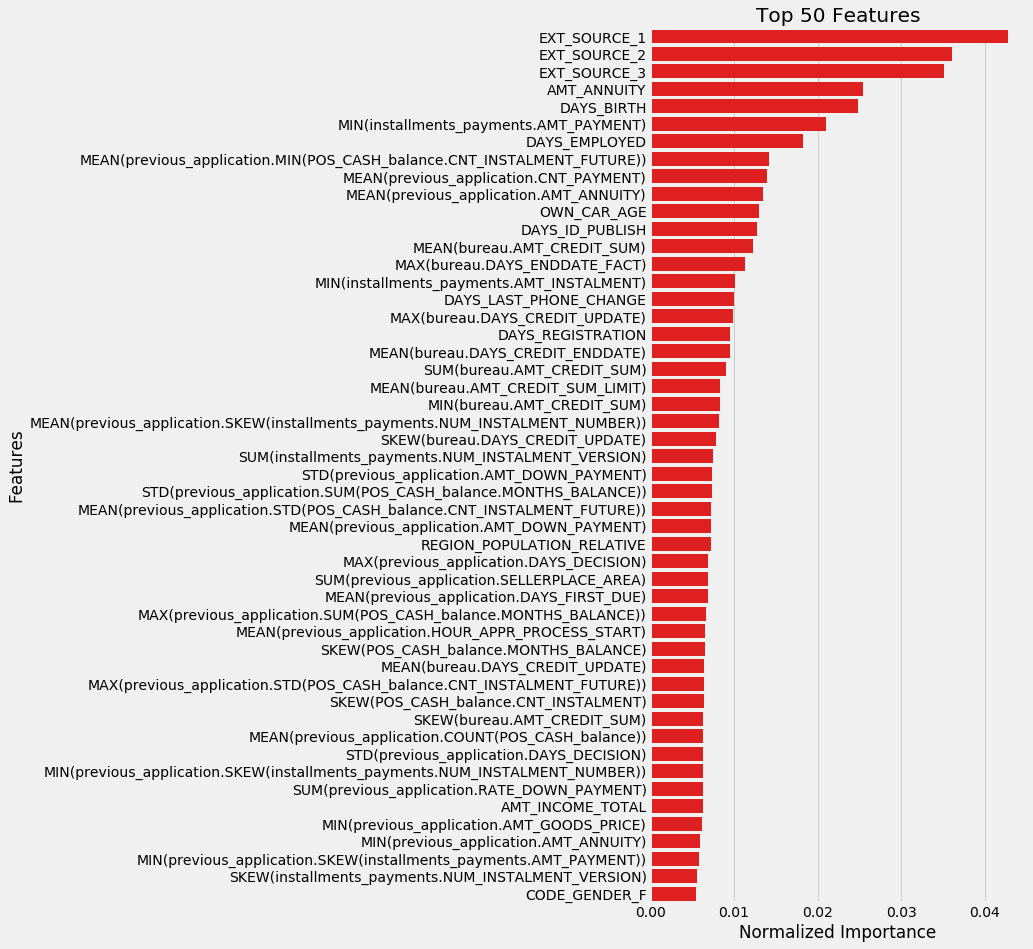

In [118]:
# Plotting top features that came from feature tool operation
top_fts_all = agg.plot_feature_importance(feature_importances)

In [125]:
# Counting the number of features that are in top 50 that came from engineered features
top_50 = top_fts_all.feature_names.tolist()
original_features = train.columns.tolist()
# list of featues in top_50 that came from feature engineering

for ft in original_features:
    if ft in top_50:
        top_50.remove(ft)

print("There are {} features genereated from features engineering and these are:\n\n{}.".format(len(top_50), top_50))


There are 38 features genereated from features engineering and these are:

['MIN(installments_payments.AMT_PAYMENT)', 'MEAN(previous_application.MIN(POS_CASH_balance.CNT_INSTALMENT_FUTURE))', 'MEAN(previous_application.CNT_PAYMENT)', 'MEAN(previous_application.AMT_ANNUITY)', 'MEAN(bureau.AMT_CREDIT_SUM)', 'MAX(bureau.DAYS_ENDDATE_FACT)', 'MIN(installments_payments.AMT_INSTALMENT)', 'MAX(bureau.DAYS_CREDIT_UPDATE)', 'MEAN(bureau.DAYS_CREDIT_ENDDATE)', 'SUM(bureau.AMT_CREDIT_SUM)', 'MEAN(bureau.AMT_CREDIT_SUM_LIMIT)', 'MIN(bureau.AMT_CREDIT_SUM)', 'MEAN(previous_application.SKEW(installments_payments.NUM_INSTALMENT_NUMBER))', 'SKEW(bureau.DAYS_CREDIT_UPDATE)', 'SUM(installments_payments.NUM_INSTALMENT_VERSION)', 'STD(previous_application.AMT_DOWN_PAYMENT)', 'STD(previous_application.SUM(POS_CASH_balance.MONTHS_BALANCE))', 'MEAN(previous_application.STD(POS_CASH_balance.CNT_INSTALMENT_FUTURE))', 'MEAN(previous_application.AMT_DOWN_PAYMENT)', 'MAX(previous_application.DAYS_DECISION)', 'SUM

There are few features that came from OneHotEncoding.